# 🐾 CNN for Multi-Class Image Classification

We will build a CNN to classify images into **Cats, Dogs, and Snakes** using PyTorch.  
The dataset should be organized in separate folders for each class.




We import **PyTorch** and **Torchvision** libraries for building the CNN and handling the dataset.


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torch import optim
from torchinfo import summary
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

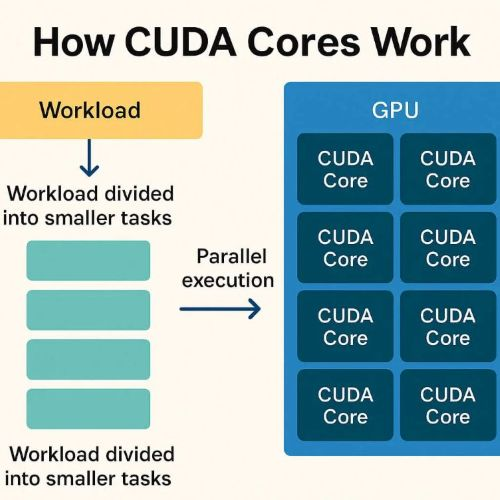

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


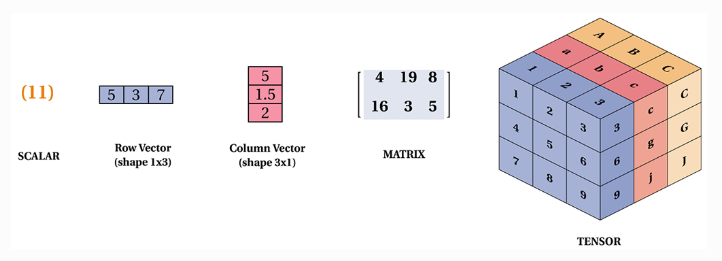



We define **transformations** to prepare images before feeding them to the CNN:
- Convert images to **RBG**
- Resize images to **224x224** (standard input size for most CNNs)  
- Convert to **tensor**  



In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])



We load the dataset using **`ImageFolder`**, which automatically assigns labels based on folder names.  


In [4]:
dataset = datasets.ImageFolder(root='data_path//Animals/', transform=transform)



We can check how many images are in our dataset using `len()`:

In [5]:
len(dataset)

3000


We can check the class names that `ImageFolder` has detected:


In [6]:
classes = dataset.classes
classes

['cats', 'dogs', 'snakes']

In [7]:
dataset[0][0].shape 

torch.Size([3, 224, 224])

In [8]:
batch_size ,height ,width = 32 , 224 , 224

In [9]:
g=torch.Generator()
g.manual_seed(42)
train_dataset,val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

In [10]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)

In [11]:
single_batch = next(iter(train_loader))[0]
single_batch.shape

torch.Size([32, 3, 224, 224])


We create a simple CNN with:
1. **Convolutional layers** → extract features like edges and textures
2. **Pooling layers** → reduce spatial dimensions
3. **Fully connected layers** → classify images into 3 classes
4. **Dropout** → prevent overfitting


 
Since we resized images to **224x224**, after **two MaxPooling layers** (stride 2), the spatial size reduces as follows:

- Input: 224 × 224  
- After first pool: 224 ÷ 2 = 112 → 112 × 112  
- After second pool: 112 ÷ 2 = 56 → 56 × 56  

Thus, the flatten size for the first fully connected layer is:  
`32 * 56 * 56 = 100352`


In [12]:
class MultiClassCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(MultiClassCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional + pooling
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        # Fully connected
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        
        # Output layer (logits, no softmax here)
        x = self.fc2(x)
        return x



We define:
- **Model**: GPU if available, else CPU  
- **Loss function**: CrossEntropyLoss for multi-class classification  
- **Optimizer**: Adam for adaptive learning

In [13]:
model = MultiClassCNN(num_classes=3).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ Summary
- **Conv2D layers** extract features from images.  
- **MaxPooling** reduces spatial dimensions, making computation efficient.  
- **Dropout** helps prevent overfitting.  
- **Fully connected layers** make the final class prediction.  
- CNNs are highly effective for tasks like **animal classification**, **object recognition**, and **medical image analysis**.


In [14]:
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
MultiClassCNN                            [32, 3]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Flatten: 1-7                           [32, 100352]              --
├─Linear: 1-8                            [32, 128]                 12,845,184
├─ReLU: 1-9                              [32, 128]                 --
├─Dropout: 1-10                          [32, 128]                 --
├─Linear: 1-11                           [32, 3]                   387
Total params: 12,850,659
Trainable params: 12,850,659
Non-trainable para

We train the CNN for a few epochs and monitor the training loss.

In [15]:
def train_model(model, train_loader, loss_fn, optimizer, device, epochs=8):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()              	# Clear gradients
            outputs = model(images)            	# Forward pass
            loss = loss_fn(outputs, labels)		# Compute loss
            loss.backward()                    	# Backpropagation
            optimizer.step()                   	# Update weights
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [16]:
train_model(model, train_loader, loss_fn, optimizer, device, epochs=5)

Epoch [1/5], Loss: 1.1744
Epoch [2/5], Loss: 0.8488
Epoch [3/5], Loss: 0.7137
Epoch [4/5], Loss: 0.6398
Epoch [5/5], Loss: 0.4784



Check how well the CNN classifies images of **cats, dogs, and snakes**.


In [17]:
def predict_eval(model, data_loader, device):
    model.eval()
    all_probs = torch.tensor([]).to(device)   # stores all prediction probabilities
    total = 0
    correct = 0
    
    with torch.no_grad():  # No gradients needed for inference
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)            # Forward pass
            probs = F.softmax(outputs, dim=1)  # Convert to probabilities
            
            # append probs for later use
            all_probs = torch.cat((all_probs, probs), dim=0)
            
            total += labels.size(0)  # total samples
            correct += (torch.argmax(probs, dim=1) == labels).sum().item()  # correct predictions
    
    accuracy = 100 * correct / total  # percentage accuracy
    return all_probs , accuracy


In [18]:
train_probs, train_accuracy = predict_eval(model, train_loader, device)
probabilities, accuracy = predict_eval(model, val_loader, device)
predicted_classes = torch.argmax(probabilities, dim=1).cpu().numpy()
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {accuracy:.2f}%")

Training Accuracy: 90.62%
Validation Accuracy: 68.50%


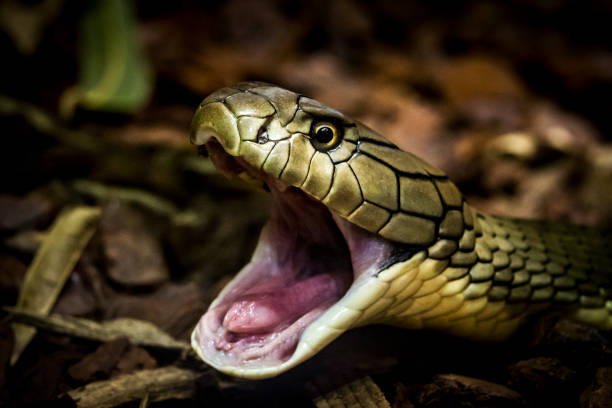

In [19]:
snake_img = Image.open("assets/snake_image.jpg")
snake_img

In [20]:
snake_img = transform(snake_img).unsqueeze(0).to(device)

In [21]:
torch.cuda.random.manual_seed(42)
output = model(snake_img)
output = F.softmax(output, dim=1)
output

tensor([[0.6008, 0.3503, 0.0488]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [22]:
predicted_class = torch.argmax(output, dim=1).item()
classes[predicted_class]

'cats'

In [23]:
target = []
for _, labels in val_loader:
    target.extend(labels.tolist())

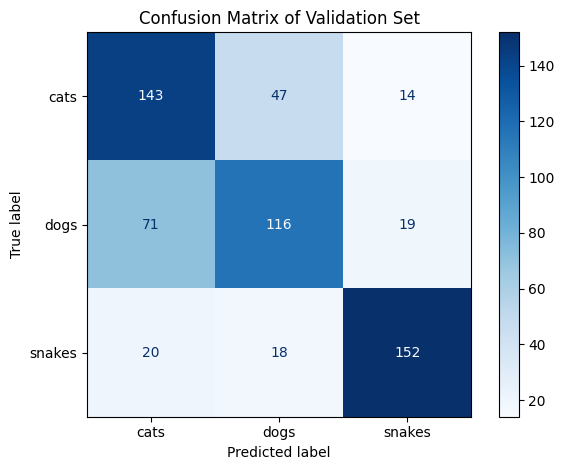

In [ ]:
cm = confusion_matrix(target, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix of Validation Set")
plt.tight_layout()
plt.show()